In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

### 1. Importing data

In [2]:
df = pd.read_csv("Bengaluru_House_Data.csv")
print("The df's shape is", df.shape)
df.head()

The df's shape is (13320, 9)


,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


### 2. Data manipulation

In [3]:
df.groupby('area_type')['area_type'].agg('count')

area_type
Built-up  Area          2418
Carpet  Area              87
Plot  Area              2025
Super built-up  Area    8790
Name: area_type, dtype: int64

In [4]:
df2 = df.drop(['area_type', 'society', 'balcony', 'availability'],axis = 'columns')
df2.head()

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00


In [5]:
# As the empty cells are not too many and the dataset is medium size, they will be dropped
df2.isnull().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [6]:
df3 = df2.dropna()
df3.shape

(13246, 5)

In [7]:
# BHK and Bedroom are the same, will proceed to make the data uniform
df3["size"].unique()

array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
       '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
       '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
       '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object)

In [8]:
df3.head()

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00


In [9]:
bhk = []
for row in df3['size']:
    number = row.split()[0]
    bhk.append(number)

In [10]:
df3['BHK'] = bhk
df3['BHK'].unique()

array(['2', '4', '3', '6', '1', '8', '7', '5', '11', '9', '27', '10',
       '19', '16', '43', '14', '12', '13', '18'], dtype=object)

In [11]:
df3['BHK'].dtypes
df3['BHK'] = df3['BHK'].astype('int')

In [12]:
print("Houses that have more than 20 rooms")
df3[df3.BHK>20]

Houses that have more than 20 rooms


,location,size,total_sqft,bath,price,BHK
1718,2Electronic City Phase II,27 BHK,8000,27.0,230.0,27
4684,Munnekollal,43 Bedroom,2400,40.0,660.0,43


In [13]:
df3.groupby('BHK')['BHK'].agg('count')

BHK
1      649
2     5527
3     4832
4     1395
5      353
6      221
7      100
8       89
9       54
10      14
11       4
12       1
13       1
14       1
16       1
18       1
19       1
27       1
43       1
Name: BHK, dtype: int64

In [14]:
df3.total_sqft.unique()
# we can observe ranges of values... are there any other possibilities than just numbers/ranges?

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      dtype=object)

In [24]:
for row in df3['total_sqft']:
    try:
        row = float(row)
    except:
        pass
        # print(row)

In [25]:
i = 0
for row in df3['total_sqft']:
    try:
        df3.at[i, 'total_sqft'] = float(row)
    except:
        if (" - "  in row) or ("-" in row):
            values = row.split(" - ")
            values = [float(x) for x in values]
            suitable_value = sum(values)/len(values)
            df3.at[i, 'total_sqft'] = suitable_value
        elif "Sq. Meter" in row:
            values = row.split("Sq.")
            suitable_value = float(values[0])
            df3.at[i, 'total_sqft'] = suitable_value * 10.7639 
        elif "Sq. Yards" in row:
            values = row.split("Sq.")
            suitable_value = float(values[0])
            df3.at[i, 'total_sqft'] = suitable_value * 9
        elif "Acres" in row:
            values = row.split("Acres")
            suitable_value = float(values[0])
            df3.at[i, 'total_sqft'] = suitable_value * 43560
        else:
            df3.drop(i)
    i += 1


In [26]:
df3.head()

,location,size,total_sqft,bath,price,BHK
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2.0
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4.0
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3.0
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3.0
4,Kothanur,2 BHK,1200.0,2.0,51.00,2.0


In [27]:
df4 = df3.copy()

In [28]:
df4["price_per_sqft"] = df3["price"]*100000/df3["total_sqft"]
df4.head()

,location,size,total_sqft,bath,price,BHK,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2.0,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4.0,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3.0,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3.0,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2.0,4250.0


In [29]:
#dimention issues, too many locations
df4 = df4.dropna()
df4.location.unique()

array(['Electronic City Phase II', 'Chikka Tirupathi', 'Uttarahalli', ...,
       '12th cross srinivas nagar banshankari 3rd stage',
       'Havanur extension', 'Abshot Layout'], dtype=object)

In [30]:
for row in df4['location']:
    if not(isinstance(row, str)):
        print(row)

In [31]:
# multiple values from the index column where skipped 
df4 = df4.reset_index(drop=True)

In [32]:
for i in range(len(df4)-1):
    locatiion = df4['location'][i]
    df4.at[i, 'location'] = locatiion.strip()
    

In [33]:
# NOTE: THIS IS THE SAME AS A FOR LOOP
location_stats_less_10 = location_stats[location_stats<=10]
len(location_stats_less_10)

1052

In [34]:
location_stats = df4.groupby('location')['location'].agg('count').sort_values(ascending=False)
location_stats

location
Whitefield               535
Sarjapur  Road           392
Electronic City          304
Kanakpura Road           266
Thanisandra              236
                        ... 
1 Giri Nagar               1
Kanakapura Road,           1
Kanakapura main  Road      1
Karnataka Shabarimala      1
whitefiled                 1
Name: location, Length: 1293, dtype: int64

In [35]:
location_stats_less_10

location
Basapura                 10
1st Block Koramangala    10
Gunjur Palya             10
Kalkere                  10
Sector 1 HSR Layout      10
                         ..
1 Giri Nagar              1
Kanakapura Road,          1
Kanakapura main  Road     1
Karnataka Shabarimala     1
whitefiled                1
Name: location, Length: 1052, dtype: int64

In [36]:
# converting those 1052 into "other"
for i in range(len(df4['location'])-1):
    if df4['location'][i] in location_stats_less_10:
         df4.at[i, 'location'] = 'other'

In [37]:
df4.groupby('location')['location'].agg('count').sort_values(ascending=False)
# only 242 different locations.

location
other               2881
Whitefield           535
Sarjapur  Road       392
Electronic City      304
Kanakpura Road       266
                    ... 
LB Shastri Nagar      11
Marsur                11
Narayanapura          11
Nehru Nagar           11
HAL 2nd Stage         11
Name: location, Length: 242, dtype: int64

In [38]:
print(df4.shape)
df4.head()

(13246, 7)


,location,size,total_sqft,bath,price,BHK,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2.0,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4.0,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3.0,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3.0,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2.0,4250.0


In [67]:
# Outliers removal
# [Bussiness domain needed] -> there is a relation between the total_sqft of a house and its bhk. 
# It is assumed that there is at least 200sqft per room.
size_totalsqft= df4[df4.total_sqft/df4.BHK<200]
print(len(size_totalsqft))


525


In [68]:
df5 = df4[~(df4.total_sqft/df4.BHK<200)]
df5.head()

,location,size,total_sqft,bath,price,BHK,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2.0,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4.0,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3.0,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3.0,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2.0,4250.0


In [69]:
df5['price_per_sqft'] = df5['price_per_sqft'].astype('int')

In [70]:
df5.price_per_sqft.describe()
df5.shape

(12721, 7)

In [71]:
# remove outliers for the price_per_sqft based on the standard deviation
df6 = pd.DataFrame()
for location, location_df in df5.groupby('location'):
    mean = np.mean(location_df.price_per_sqft)
    std = np.std(location_df.price_per_sqft)
    reduced_df = location_df[(location_df.price_per_sqft>(mean - std)) & (location_df.price_per_sqft<=(mean + std))]
    df6 = pd.concat([df6,reduced_df], ignore_index = True)

In [72]:
df6.shape

(10643, 7)

In [73]:
# another thing to check is that houses as a maximun have 2 bathrooms more than its amount of BHK... reducing outliers
df6 = df6[(df6.BHK+2 > df6.bath)]
df6.shape

(10577, 7)

In [74]:
df6.head()

,location,size,total_sqft,bath,price,BHK,price_per_sqft
0,1st Block Jayanagar,4 BHK,1580.0,4.0,428.0,4.0,27088
1,1st Block Jayanagar,3 BHK,900.0,3.0,194.0,3.0,21555
2,1st Block Jayanagar,3 BHK,1800.0,2.0,235.0,3.0,13055
3,1st Block Jayanagar,2 BHK,1320.0,3.0,60.0,2.0,4545
4,1st Block Jayanagar,8 Bedroom,1610.0,4.0,104.0,8.0,6459


We should also remove properties where for same location, the price of (for example) 3 bedroom apartment is less than 2 bedroom apartment (with same square ft area).For that, we will build a dictionary of stats per bhk, i.e.

{
    '1' :   {
        'mean': 4000,
        'std: 2000,
        'count': 34
    },
    
   '2' : {
        'mean': 4300,
        'std: 2300,
        'count': 22
    }   }

Now let's remove the 2 BHK apartments whose price_per_sqft < price_per_sqft of 1 BHK apartment

In [75]:
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('BHK'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('BHK'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')

new_df = remove_bhk_outliers(df6)
new_df.shape

(8485, 7)

### 3. Data exploration

In [76]:
locations = new_df.groupby('location')['location'].agg('count').sort_values(ascending=False)
locations

location
other                        1569
Whitefield                    353
Sarjapur  Road                256
Electronic City               207
Kanakpura Road                143
                             ... 
Thyagaraja Nagar                6
2nd Phase Judicial Layout       6
Marsur                          6
Banjara Layout                  5
Vishwapriya Layout              5
Name: location, Length: 242, dtype: int64

<AxesSubplot:title={'center':'How many times does each location exist?'}, xlabel='location'>

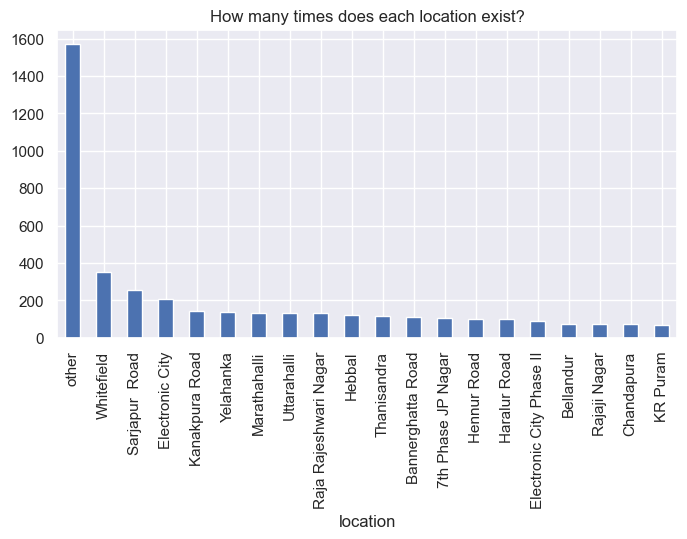

In [77]:
fig = plt.figure(figsize = (8,4))
pd.Series(locations[0:20]).plot(kind='bar', title='How many times does each location exist?')

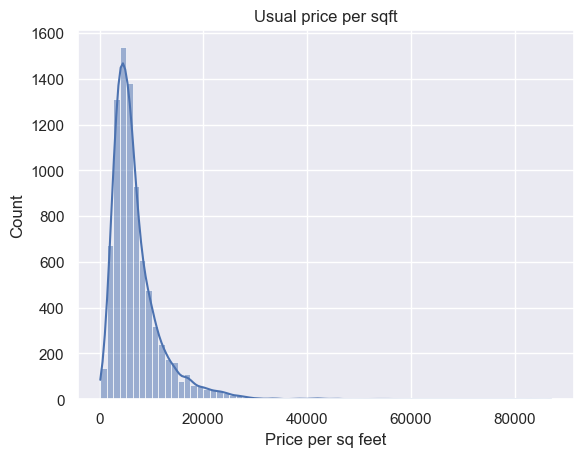

<Figure size 500x200 with 0 Axes>

In [78]:
sns.histplot(data=new_df, x=new_df['price_per_sqft'], bins=70,kde=True).set(title='Usual price per sqft')
plt.xlabel("Price per sq feet")
fig = plt.figure(figsize = (5,2))
sns.set(style="darkgrid")
plt.show()

Text(0, 0.5, 'Count')

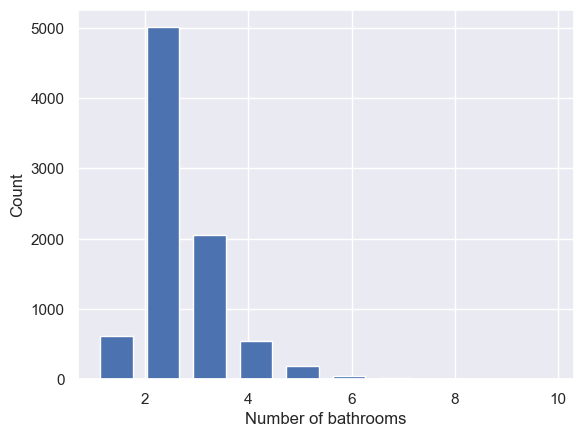

In [79]:
plt.hist(new_df.bath, rwidth=0.7)
plt.xlabel("Number of bathrooms")
plt.ylabel("Count")

Area types are ['Super built-up  Area' 'Plot  Area' 'Built-up  Area' 'Carpet  Area']


<AxesSubplot:>

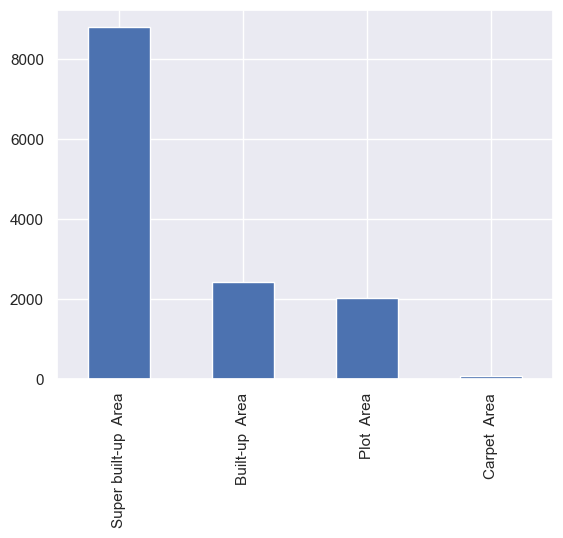

In [80]:
print("Area types are",df['area_type'].unique())
pd.value_counts(df['area_type']).plot.bar()

### 4. Data Preprocessing

In [81]:
dummies = pd.get_dummies(new_df.location)
dummies.head()

,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [82]:
# if all the locations' values are 0, it is other
df7 = pd.concat([new_df, dummies.drop('other',axis='columns')],axis='columns')
df7 = df7.drop('location', axis='columns')
df7.head()

,size,total_sqft,bath,price,BHK,price_per_sqft,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,4 BHK,1580.0,4.0,428.0,4.0,27088,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3 BHK,900.0,3.0,194.0,3.0,21555,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3 BHK,1800.0,2.0,235.0,3.0,13055,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2 BHK,1320.0,3.0,60.0,2.0,4545,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8 Bedroom,1610.0,4.0,104.0,8.0,6459,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [83]:
for i in df7.columns:
    try:
        df7[[i]] = df7[[i]].astype(float).astype(int)
    except:
        pass

print(df7.dtypes)


size                  object
total_sqft             int32
bath                   int32
price                  int32
BHK                    int32
                       ...  
Yelachenahalli         int32
Yelahanka              int32
Yelahanka New Town     int32
Yelenahalli            int32
Yeshwanthpur           int32
Length: 247, dtype: object


In [84]:
# getting the independant variable for training the model
X = df7.drop(['price','size', 'price_per_sqft'], axis = 'columns')
X.head()

,total_sqft,bath,BHK,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1580,4,4,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,900,3,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1800,2,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1320,3,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1610,4,8,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [85]:
y = df7['price']
y.head()

0    428
1    194
2    235
3     60
4    104
Name: price, dtype: int32

### 5. Training the model

Deciding which model:

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 10)

In [87]:
linear_regression = LinearRegression()
linear_regression.fit(X_train,y_train)


LinearRegression()

In [88]:
print("Score for LinearRegression is ",linear_regression.score(X_test, y_test))

Score for LinearRegression is  0.5969400554682367


In [89]:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
cross_val_score(LinearRegression(), X, y, cv=cv)

array([0.59147965, 0.5296281 , 0.59541597, 0.53306376, 0.58213472])

Assessment of the model:

In [90]:
def find_best_model(X,y):
    posibilities = {
        'linear_regression': {
            'model': LinearRegression(),
            'params': {
                'normalize': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1,2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion': ['mse', 'friedman_mse'],
                'splitter': ['best', 'random']
            }
        }
    }
    
    scores = []
    # cross-validation to randomly shuffle the samples
    cv= ShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 0)
    # GridSearch to go through the python dictionary to use the different ml models
    for name, config in posibilities.items():
        gs = GridSearchCV(config['model'], config['params'], cv=cv, return_train_score= False)
        gs.fit(X,y)
        print(gs.best_score_)
        scores.append({
            'model': name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })
        
    return pd.DataFrame(scores, columns= ['model', 'best_score', 'best_params'])

In [91]:
df_possibilities = find_best_model(X, y)
df_possibilities

0.5663444413825252
0.3626907054693761
0.29427230219413447


,model,best_score,best_params
0,linear_regression,0.566344,{'normalize': True}
1,lasso,0.362691,"{'alpha': 1, 'selection': 'random'}"
2,decision_tree,0.294272,"{'criterion': 'friedman_mse', 'splitter': 'best'}"


We can observe from the dataset that the model that gives the best accuracy score is the decision tree regressor. Therefore, that is the model that will be used with a model.score of 0.98.

In [64]:
model = tree.DecisionTreeRegressor(criterion= "friedman_mse", splitter= "best")
model.fit(X_train, y_train)

DecisionTreeRegressor(criterion='friedman_mse')

In [65]:
model.score(X_test, y_test)

0.16112194379824374

In [66]:
print("the inputs that the user can give are ", X.columns)

#example of how loc_index finds the index of the column sent as the location
loc_index = np.where(X.columns == '1st Block Jayanagar')[0][0]
print(loc_index)

the inputs that the user can give are  Index(['total_sqft', 'bath', 'BHK', '1st Block Jayanagar',
       '1st Phase JP Nagar', '2nd Phase Judicial Layout',
       '2nd Stage Nagarbhavi', '5th Block Hbr Layout', '5th Phase JP Nagar',
       '6th Phase JP Nagar',
       ...
       'Vijayanagar', 'Vishveshwarya Layout', 'Vishwapriya Layout',
       'Vittasandra', 'Whitefield', 'Yelachenahalli', 'Yelahanka',
       'Yelahanka New Town', 'Yelenahalli', 'Yeshwanthpur'],
      dtype='object', length=244)
3


In [ ]:
def predict(location, total_sqft, bath, BHK):
    